In [22]:
import pandas as pd
from datetime import datetime, timezone, timedelta
import pytz
import matplotlib
import matplotlib.pyplot as plt
import sqlite3

db = sqlite3.connect("./scores.db")

with open("data/output.csv", "rb") as f:
    data = pd.read_csv(f, delimiter="\t")

[datetime.datetime(2024, 1, 1, 0, 0), datetime.datetime(2024, 1, 15, 0, 0), datetime.datetime(2024, 1, 17, 0, 0), datetime.datetime(2024, 1, 18, 0, 0), datetime.datetime(2024, 1, 20, 0, 0), datetime.datetime(2024, 1, 27, 0, 0), datetime.datetime(2024, 1, 29, 0, 0), datetime.datetime(2024, 2, 1, 0, 0), datetime.datetime(2024, 2, 3, 0, 0), datetime.datetime(2024, 2, 4, 0, 0), datetime.datetime(2024, 2, 20, 0, 0), datetime.datetime(2024, 3, 4, 0, 0), datetime.datetime(2024, 3, 5, 0, 0), datetime.datetime(2024, 3, 10, 0, 0), datetime.datetime(2024, 3, 12, 0, 0), datetime.datetime(2024, 3, 14, 0, 0), datetime.datetime(2024, 3, 23, 0, 0), datetime.datetime(2024, 3, 27, 0, 0), datetime.datetime(2024, 3, 28, 0, 0), datetime.datetime(2024, 4, 3, 0, 0), datetime.datetime(2024, 4, 5, 0, 0), datetime.datetime(2024, 4, 9, 0, 0), datetime.datetime(2024, 4, 11, 0, 0), datetime.datetime(2024, 4, 13, 0, 0), datetime.datetime(2024, 4, 14, 0, 0), datetime.datetime(2024, 4, 17, 0, 0), datetime.datetime(20

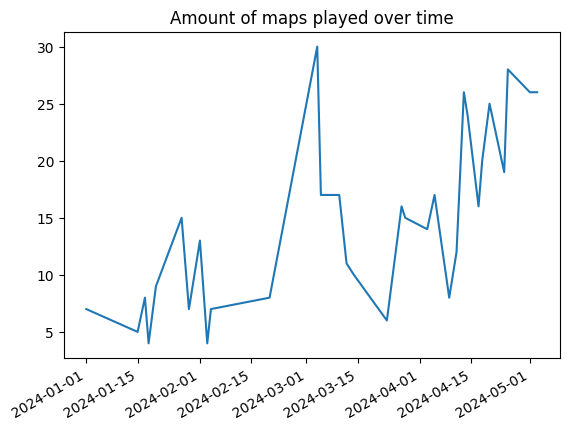

In [32]:
from datetime import date, datetime
c = db.cursor()
result = c.execute("""
    SELECT COUNT(*), UNIXEPOCH(DATE(scores."Time Played")) as date FROM scores
    GROUP BY date
""")
result = list(result)
result.sort(key=lambda x: x[1])
y, x = list(zip(*result))
dates = list(map(lambda x: datetime.utcfromtimestamp(x), x))
# dates = matplotlib.dates.date2num(x)
print(dates)
plt.title("Amount of maps played per session over time")
plt.xticks(rotation=45, ha="right")
plt.plot(dates, y)
plt.gcf().autofmt_xdate()
plt.show()

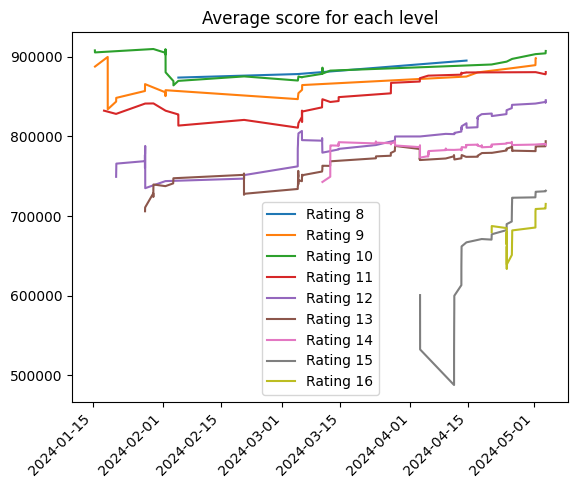

In [48]:
from statistics import mean
from datetime import datetime

c = db.cursor()
ratings = list(map(lambda r: r[0], c.execute("select distinct Rating from scores")))
ratings.sort()

for rating in ratings:
    result = c.execute('select "Song ID", UNIXEPOCH("Time Played"), "Song Name", Score from scores where Rating = ? order by "Time Played"', (rating,))
    scores = dict()
    xs = []
    ys = []
    for record in result:
        song_id, time_played, song_name, score = record
        date = datetime.utcfromtimestamp(time_played)
        scores[song_id] = score
        values = list(scores.values())
        avg = mean(values)
        if len(values) >= 5:
            xs.append(date)
            ys.append(avg)

    if xs and ys:
        plt.plot(xs, ys, label=f"Rating {rating}")

plt.legend()
plt.xticks(rotation=45, ha="right")
plt.title("Average score for each level")
plt.show()

In [24]:
JST = pytz.timezone("Asia/Tokyo")
CST = pytz.timezone("America/Chicago")

def to_jst_timestamp(s: str, format_str="%Y-%m-%d %H:%M:%S"):
    if type(s) is not str: return None
    naive_dt = datetime.strptime(s, format_str)
    jst_dt = JST.localize(naive_dt)
    cst_dt = jst_dt.astimezone(CST)
    return cst_dt

times = data["Time Played"]
times_mapped = times.map(to_jst_timestamp)
days_played = times_mapped.groupby(times_mapped.dt.date).count()
print(days_played.sort_values(ascending=False).head(10))

Time Played
2024-03-04    29
2024-05-03    26
2024-05-01    26
2024-04-14    24
2024-04-25    23
2024-04-13    23
2024-04-20    20
2024-04-18    20
2024-04-24    17
2024-03-10    17
Name: Time Played, dtype: int64


In [25]:
records_by_level = data.loc[data["Lamp"] != "Fail"].groupby(data["Rating"])
num_clears_by_level = records_by_level["Score"].count().rename("Clears")
average_scores_by_level = records_by_level["Score"].mean().round().astype("int").rename("Average")
def max_info(group):
    max_idx = group["Score"].idxmax()
    return group.loc[max_idx][["Score", "Lamp", "Song Name"]].rename({ "Score": "Max Score", "Lamp": "Max Score Lamp", "Song Name": "Max Score Song" })
max_score_by_level = records_by_level.apply(max_info)
result = pd.merge(num_clears_by_level, average_scores_by_level, on="Rating")
result = pd.merge(result, max_score_by_level, on="Rating")
with pd.option_context('expand_frame_repr', False):
    print(result)

        Clears  Average  Max Score Max Score Lamp                          Max Score Song
Rating                                                                                   
8            7   895073     996620            GFC                       朧 (dj TAKA Remix)
9           25   918551     999650            PFC                                 Why not
10          31   923955     992160            GFC                                  隅田川夏恋歌
11          43   897455     992520            GFC                                       朧
12          59   892278     987030            GFC                          MY SUMMER LOVE
13          72   841207     978430            GFC                                Struggle
14         122   800595     943140             FC                      FUNKY SUMMER BEACH
15          26   800125     900060          Clear                              ナイト・オブ・ナイツ
16          18   772837     861210          Clear                      Sword of Vengeance
17        

In [26]:
# Gold 1
gold1scores = []
gold1scores.append(data[(data["Score"] >= 975000) & (data["Rating"] == 13)].head(1))
gold1scores.append(data[(data["Score"] >= 925000) & (data["Rating"] == 14)].head(1))
gold1scores.append(data[(data["Score"] >= 875000) & (data["Rating"] == 15)].head(1))
gold1scores.append(data[(data["Score"] >= 825000) & (data["Rating"] == 16)].head(1))
gold1scores.append(data[(data["Score"] >= 750000) & (data["Rating"] == 17)].head(1))
with pd.option_context('expand_frame_repr', False):
    gold1scores = pd.concat(gold1scores)
    print(gold1scores)

                              Song ID           Song Name Difficulty  Rating   Score Grade   Lamp        Time Uploaded          Time Played
42   1idIoi66ll806D8ddldOQi8bdiDO0Oil            Struggle        ESP      13  978430   AA+    GFC  2024-04-18 18:14:49  2024-04-18 18:05:47
125  9i6dOd608qb0IlqoDIPb8q1o8q1ddQQd  FUNKY SUMMER BEACH        ESP      14  943140    AA     FC  2024-05-01 22:11:00  2024-05-01 19:21:38
57   1qPIiqqQo0P9dD90I11q90b0ooIidbPO        CyberConnect        ESP      15  889000    A+  Clear  2024-05-04 04:48:08  2024-05-04 04:24:34
211  ddqO1b1ldlQd6OOoQ1boPdoboDQqd9D8  Sword of Vengeance        ESP      16  861210    A+  Clear  2024-05-01 18:42:28  2024-05-01 18:39:33
